In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Dense, Embedding, LSTM, Dropout, Activation, TimeDistributed, BatchNormalization
from keras.layers.merge import concatenate
from keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix


from dataprep import get_vectors, get_data

import tensorflow as tf
import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings('ignore')

In [2]:
# To calculate on GPU
# https://github.com/tensorflow/tensorflow/issues/33721
TF_FORCE_GPU_ALLOW_GROWTH=1
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [3]:
# CONSTANTS
seed = 42

In [4]:
cmt_pos = pd.read_csv('../../data/prepared/no_trans_stem_pos.csv')
cmt_neg = pd.read_csv('../../data/prepared/no_trans_stem_neg.csv')
X, Y, vocab_size, emdedding_size = get_data(cmt_pos, cmt_neg, 0)
vectors = get_vectors(0).vectors
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=seed, test_size=0.3, stratify=Y, shuffle=True)
# check if the data is evenly split
import collections
print('Train labels: ', collections.Counter(y_train))
print('Test labels: ', collections.Counter(y_test))

Train labels:  Counter({1: 965, 0: 965})
Test labels:  Counter({1: 414, 0: 414})


In [5]:
# Cross validation setup
sk = StratifiedKFold(n_splits = 3, random_state = seed, shuffle = True) 

In [6]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4)

In [7]:
adamOptimizer = Adam(lr=0.0001)

In [8]:
def plot_history(history_arrs, train, val, xlabel, ylabel, plot_title):
    if len(history_arrs) == 1:
        history = history_arrs[0]
        plt.plot(history['accuracy'])
        plt.plot(history['val_accuracy'])
        plt.title(plot_title)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()
    else:
        f, a = plt.subplots(1, len(history_arrs), figsize=(10,5))
        for idx, history in enumerate(history_arrs):
            # For Sine Function
            a[idx].plot(history[train])
            a[idx].plot(history[val])
            title = plot_title + ' ' + str(idx)
            a[idx].set_title(title)
            a[idx].set_xlabel(xlabel)
            a[idx].set_ylabel(ylabel)
            a[idx].legend(['Train', 'Validation'], loc='upper left')
        f.tight_layout()
        plt.show()

In [9]:
def run_test(model_func, Xtrain, ytrain, X_test, y_test, embedding_layer):
    results = []
    histories = []
    best_model = None
    best_acc = 0
    for train_index, val_index in sk.split(X_train, y_train):
        Xt, Xv = Xtrain[train_index], Xtrain[val_index]
        yt, yv = ytrain[train_index], ytrain[val_index]
        model = model_func(embedding_layer)
        history = model.fit(Xt, yt, validation_data=(Xv, yv), epochs=30, batch_size=16, verbose = 0, callbacks=[early_stopping])
        histories.append(history.history)
        loss, acc = model.evaluate(X_test, y_test, verbose = 0, batch_size = 16)
        if best_acc < acc:
            best_model = model
        results.append([loss, acc])
    results = np.array(results)
    return results, histories, model

In [13]:
def model_1(embedding_layer):
    model = Sequential()
    model.add(embedding_layer)
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer=adamOptimizer, metrics = ['accuracy'])
    return model

In [10]:
def calculate_metrics(model, X_test, y_test):
    ypred_class = model.predict_classes(X_test, verbose=0)
    ypred_class = ypred_class[:, 0]
    accuracy = accuracy_score(y_test, ypred_class)
    precision = precision_score(y_test, ypred_class)
    recall = recall_score(y_test, ypred_class)
    f1 = f1_score(y_test, ypred_class)
    conf_matrix = confusion_matrix(y_test, ypred_class)
    return accuracy, precision, recall, f1, conf_matrix

In [11]:
def print_conf_matrix(conf_matrix):
    cm = pd.DataFrame(
    conf_matrix, 
    index=['true:positive', 'true:negative'], 
    columns=['pred:positive', 'pred:negative']
    )
    print(cm)

# Model 1

First model cross-validation and without pretrained word vector

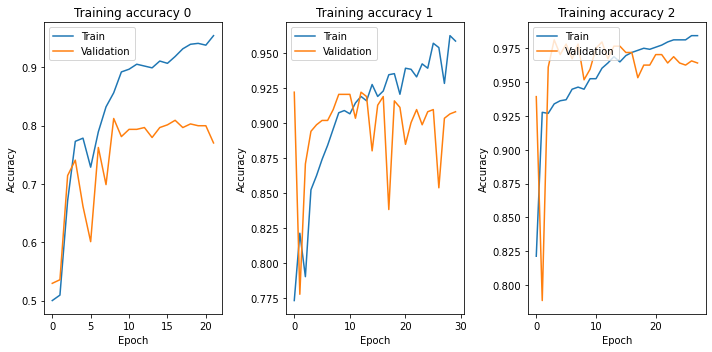

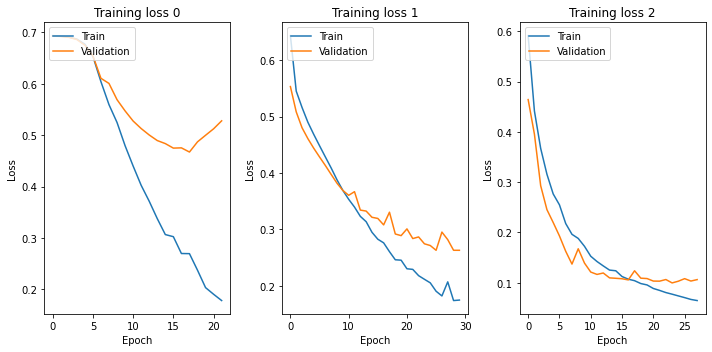

Average model 1 accuracy of cross validation on unseen data: 0.8148
The best perfoming model statistics with class predictions: 
Accuracy: 0.8345
Precision: 0.8155
Recall: 0.8647
F1 score: 0.8394
Confusion matrix:
               pred:positive  pred:negative
true:positive            333             81
true:negative             56            358


In [14]:
embedding_layer = Embedding(X.max()+1, 32, input_length=X.shape[1], trainable = True)
results, histories, model = run_test(model_1, X_train, y_train, X_test, y_test, embedding_layer)
# Plots
# Accuracy
plot_history(histories, 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy') 
# Loss
plot_history(histories, 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Average model 1 accuracy of cross validation on unseen data: %.4f' % results[:, 1].mean())
print('The best perfoming model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

Model evaluation without pretrained word vector

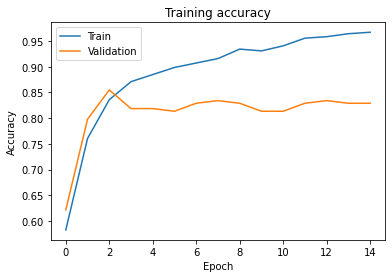

Model statistics with class predictions: 
Accuracy: 0.8188
Precision: 0.8220
Recall: 0.8140
F1 score: 0.8180
Confusion matrix:
               pred:positive  pred:negative
true:positive            341             73
true:negative             77            337


In [15]:
embedding_layer = Embedding(X.max()+1, 32, input_length=X.shape[1], trainable = True)
model = model_1(embedding_layer)
Xtrain, Xval, ytrain, yval = train_test_split(X_train, y_train, random_state=seed, test_size=0.1, stratify=y_train, shuffle=True)
history = model.fit(Xtrain, ytrain, validation_data=(Xval, yval), epochs=30, batch_size=16, verbose = 0, callbacks=[early_stopping])
plot_history([history.history], 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

In [16]:
# Save the model (weights, architecture)
model.save('../../models/models/bilstm-nowv')

INFO:tensorflow:Assets written to: ../../models/models/bilstm-nowv\assets


INFO:tensorflow:Assets written to: ../../models/models/bilstm-nowv\assets


First model cross-validation with pretrained word vectors

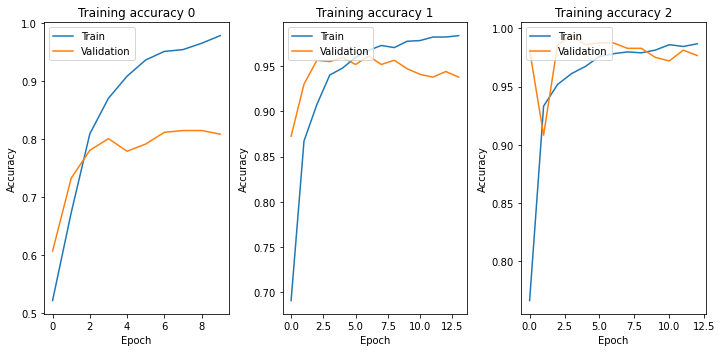

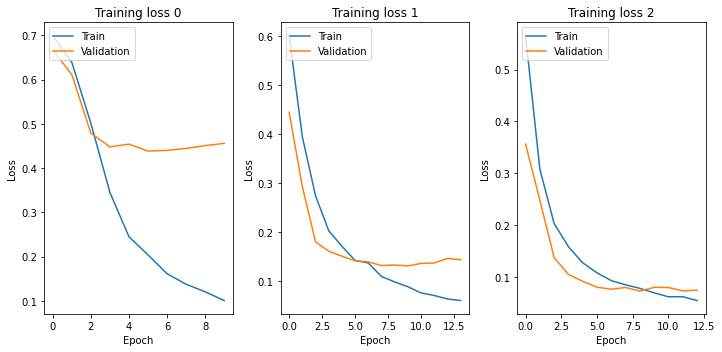

Average model 1 accuracy of cross validation on unseen data: 0.8285
The best perfoming model statistics: 
Accuracy: 0.8382
Precision: 0.8608
Recall: 0.8068
F1 score: 0.8329
Confusion matrix:
               pred:positive  pred:negative
true:positive            360             54
true:negative             80            334


In [17]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=emdedding_size, weights=[vectors], trainable=True)
results, histories, model = run_test(model_1, X_train, y_train, X_test, y_test, embedding_layer)
# Plots
# Accuracy
plot_history(histories, 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy') 
# Loss
plot_history(histories, 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Average model 1 accuracy of cross validation on unseen data: %.4f' % results[:, 1].mean())
print('The best perfoming model statistics: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

First model evaluation with pretrained word vectors.

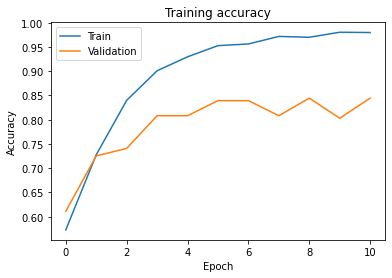

Model statistics with class predictions: 
Accuracy: 0.8200
Precision: 0.8177
Recall: 0.8237
F1 score: 0.8207
Confusion matrix:
               pred:positive  pred:negative
true:positive            338             76
true:negative             73            341


In [18]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=emdedding_size, weights=[vectors], trainable=True)
model = model_1(embedding_layer)
Xtrain, Xval, ytrain, yval = train_test_split(X_train, y_train, random_state=seed, test_size=0.1, stratify=y_train, shuffle=True)
history = model.fit(Xtrain, ytrain, validation_data=(Xval, yval), epochs=30, batch_size=16, verbose = 0, callbacks=[early_stopping])
plot_history([history.history], 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

In [19]:
# Save the model (weights, architecture)
model.save('../../models/models/bilstm-wv')

INFO:tensorflow:Assets written to: ../../models/models/bilstm-wv\assets


INFO:tensorflow:Assets written to: ../../models/models/bilstm-wv\assets


# Model 2

In [20]:
def model_2(embedding_layer):
    model = Sequential()
    model.add(embedding_layer)
    model.add(Bidirectional(LSTM(128)))
    model.add(Dense(32))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer=adamOptimizer, metrics = ['accuracy'])
    return model

Second model cross-validation without pretrained word vectors

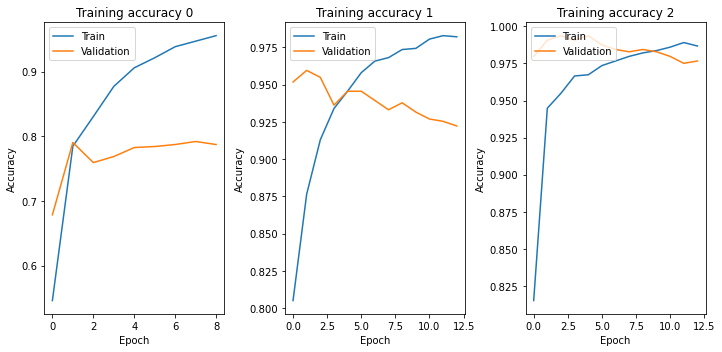

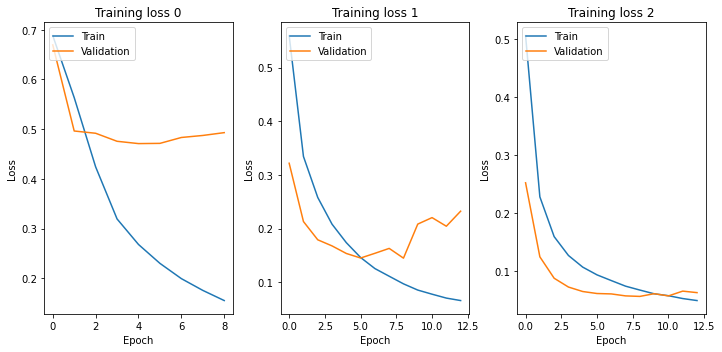

Average model 2 accuracy of cross validation on unseen data: 0.8196
The best perfoming model statistics with class predictions: 
Accuracy: 0.8321
Precision: 0.8235
Recall: 0.8454
F1 score: 0.8343
Confusion matrix:
               pred:positive  pred:negative
true:positive            339             75
true:negative             64            350


In [21]:
embedding_layer = Embedding(X.max()+1, 32, input_length=X.shape[1], trainable = True)
results, histories, model = run_test(model_2, X_train, y_train, X_test, y_test, embedding_layer)
# Plots
# Accuracy
plot_history(histories, 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy') 
# Loss
plot_history(histories, 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Average model 2 accuracy of cross validation on unseen data: %.4f' % results[:, 1].mean())
print('The best perfoming model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

Second model evaluation without pretrained word vectors.

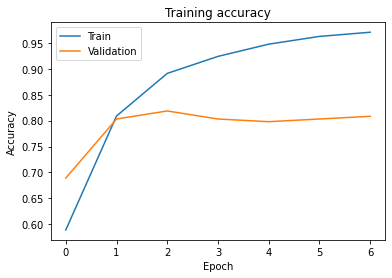

Model statistics with class predictions: 
Accuracy: 0.8140
Precision: 0.8299
Recall: 0.7899
F1 score: 0.8094
Confusion matrix:
               pred:positive  pred:negative
true:positive            347             67
true:negative             87            327


In [22]:
embedding_layer = Embedding(X.max()+1, 32, input_length=X.shape[1], trainable = True)
model = model_2(embedding_layer)
Xtrain, Xval, ytrain, yval = train_test_split(X_train, y_train, random_state=seed, test_size=0.1, stratify=y_train, shuffle=True)
history = model.fit(Xtrain, ytrain, validation_data=(Xval, yval), epochs=30, batch_size=16, verbose = 0, callbacks=[early_stopping])
plot_history([history.history], 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

In [23]:
# Save best performing model (weights, architecture)
model.save('../../models/models/bilstm2-nowv')

INFO:tensorflow:Assets written to: ../../models/models/bilstm2-nowv\assets


INFO:tensorflow:Assets written to: ../../models/models/bilstm2-nowv\assets


Second model cross-validation with pretrained word vectors

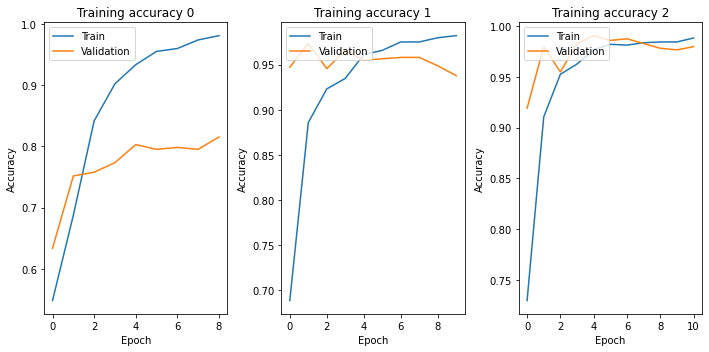

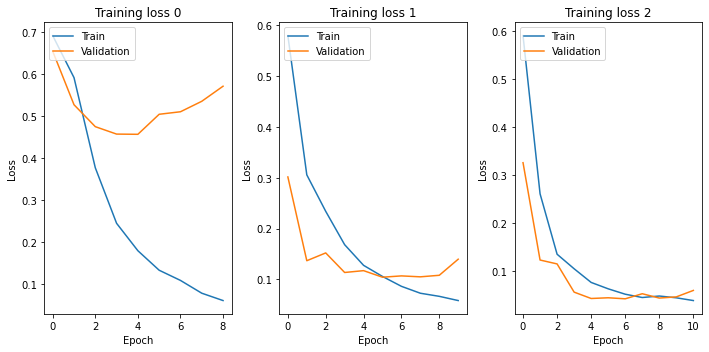

Average model 2 accuracy of cross validation on unseen data: 0.8108
The best perfoming model statistics: 
Accuracy: 0.8056
Precision: 0.7856
Recall: 0.8406
F1 score: 0.8121
Confusion matrix:
               pred:positive  pred:negative
true:positive            319             95
true:negative             66            348


In [24]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=emdedding_size, weights=[vectors], trainable=True)
results, histories, model = run_test(model_2, X_train, y_train, X_test, y_test, embedding_layer)
# Plots
# Accuracy
plot_history(histories, 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy') 
# Loss
plot_history(histories, 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Average model 2 accuracy of cross validation on unseen data: %.4f' % results[:, 1].mean())
print('The best perfoming model statistics: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

Second model evaluation with pretrained word vectors

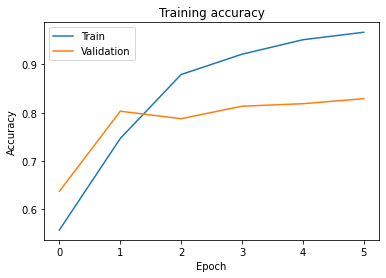

Model statistics with class predictions: 
Accuracy: 0.7947
Precision: 0.8885
Recall: 0.6739
F1 score: 0.7665
Confusion matrix:
               pred:positive  pred:negative
true:positive            379             35
true:negative            135            279


In [25]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=emdedding_size, weights=[vectors], trainable=True)
model = model_2(embedding_layer)
Xtrain, Xval, ytrain, yval = train_test_split(X_train, y_train, random_state=seed, test_size=0.1, stratify=y_train, shuffle=True)
history = model.fit(Xtrain, ytrain, validation_data=(Xval, yval), epochs=30, batch_size=16, verbose = 0, callbacks=[early_stopping])
plot_history([history.history], 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

In [26]:
model.save('../../models/models/bilstm2-wv')

INFO:tensorflow:Assets written to: ../../models/models/bilstm2-wv\assets


INFO:tensorflow:Assets written to: ../../models/models/bilstm2-wv\assets


# Model architecture tests on IMDB dataset

In [27]:
# IMDB dataset
from keras.datasets import imdb
word_count = 5000
(X_train_imdb, y_train_imdb), (X_test_imdb, y_test_imdb) = imdb.load_data(num_words=word_count)
max_length = 500
X_train_imdb = sequence.pad_sequences(X_train_imdb, maxlen=max_length)
X_test_imdb = sequence.pad_sequences(X_test_imdb, maxlen=max_length)

## Model 1

First model cross-validation

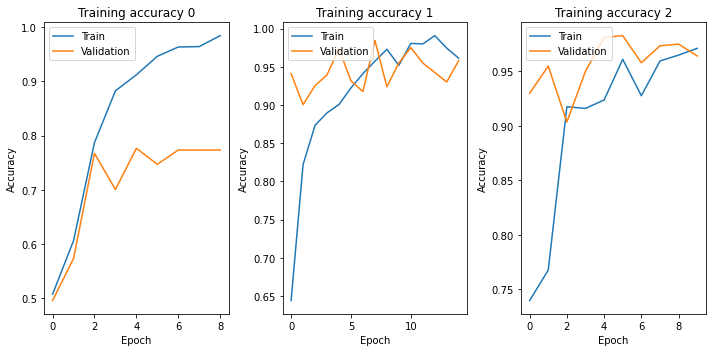

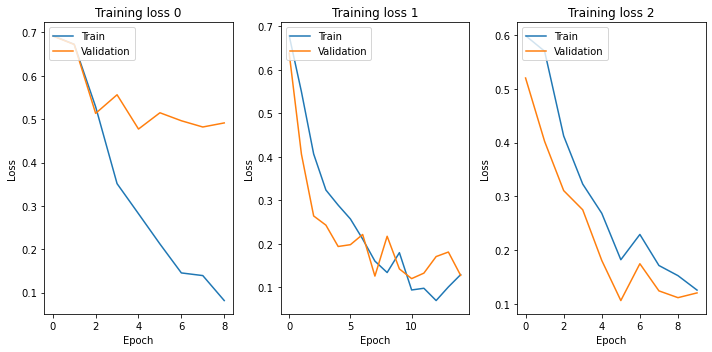

Average model 1 accuracy of cross validation on unseen IMDB data: 0.8046
The best perfoming model statistics: 
Accuracy: 0.7945
Precision: 0.7840
Recall: 0.8130
F1 score: 0.7982
Confusion matrix:
               pred:positive  pred:negative
true:positive           9701           2799
true:negative           2338          10162


In [30]:
embedding_layer = Embedding(word_count, 32, input_length=max_length)
results, histories, model = run_test(model_1, X_train_imdb, y_train_imdb, X_test_imdb, y_test_imdb, embedding_layer)
# Plots
# Accuracy
plot_history(histories, 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy') 
# Loss
plot_history(histories, 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test_imdb, y_test_imdb)
print('Average model 1 accuracy of cross validation on unseen IMDB data: %.4f' % results[:, 1].mean())
print('The best perfoming model statistics: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

First model performance evaluation

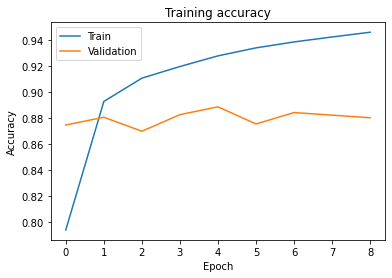

Model statistics with class predictions: 
Accuracy: 0.8733
Precision: 0.8631
Recall: 0.8873
F1 score: 0.8750
Confusion matrix:
               pred:positive  pred:negative
true:positive          10741           1759
true:negative           1409          11091


In [31]:
embedding_layer = Embedding(word_count, 32, input_length=max_length)
model = model_1(embedding_layer)
Xtrain_imdb, Xval_imdb, ytrain_imdb, yval_imdb = train_test_split(X_train_imdb, y_train_imdb, random_state=seed, test_size=0.1, stratify=y_train_imdb, shuffle=True)
history = model.fit(Xtrain_imdb, ytrain_imdb, validation_data=(Xval_imdb, yval_imdb), epochs=30, batch_size=16, verbose = 0, callbacks=[early_stopping])
plot_history([history.history], 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test_imdb, y_test_imdb)
print('Model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

## Model 2

Second model cross-validation

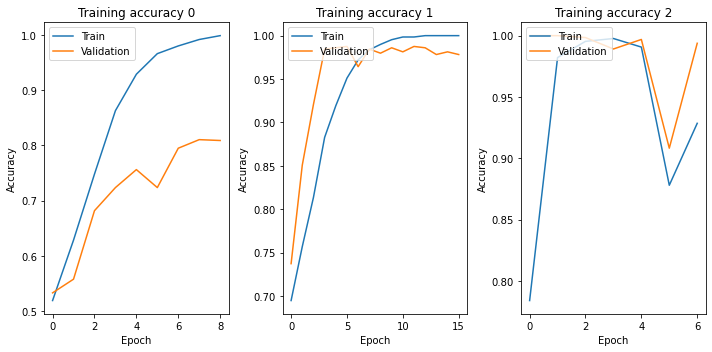

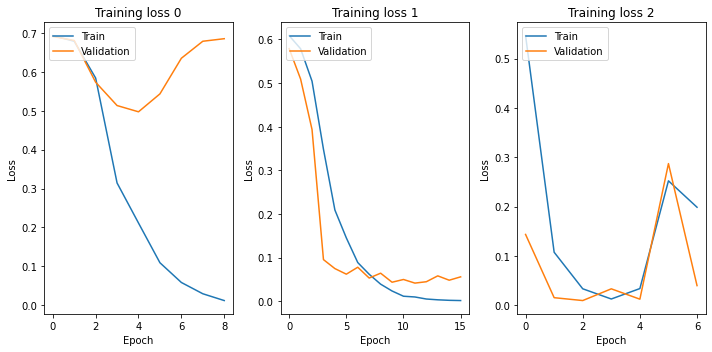

Average model 2 accuracy of cross validation on unseen IMDB data: 0.8044
The best perfoming model statistics: 
Accuracy: 0.7999
Precision: 0.7772
Recall: 0.8409
F1 score: 0.8078
Confusion matrix:
               pred:positive  pred:negative
true:positive           9486           3014
true:negative           1989          10511


In [32]:
embedding_layer = Embedding(word_count, 32, input_length=max_length)
results, histories, model = run_test(model_2, X_train_imdb, y_train_imdb, X_test_imdb, y_test_imdb, embedding_layer)
# Plots
# Accuracy
plot_history(histories, 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy') 
# Loss
plot_history(histories, 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test_imdb, y_test_imdb)
print('Average model 2 accuracy of cross validation on unseen IMDB data: %.4f' % results[:, 1].mean())
print('The best perfoming model statistics: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

Second model evaluation

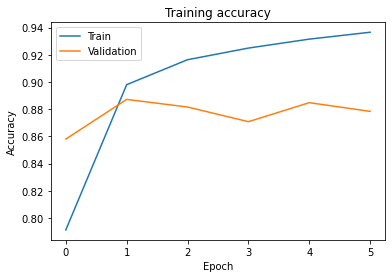

Model 2 statistics with class predictions: 
Accuracy: 0.8721
Precision: 0.9058
Recall: 0.8306
F1 score: 0.8666
Confusion matrix:
               pred:positive  pred:negative
true:positive          11420           1080
true:negative           2117          10383


In [33]:
embedding_layer = Embedding(word_count, 32, input_length=max_length)
model = model_2(embedding_layer)
Xtrain_imdb, Xval_imdb, ytrain_imdb, yval_imdb = train_test_split(X_train_imdb, y_train_imdb, random_state=seed, test_size=0.1, stratify=y_train_imdb, shuffle=True)
history = model.fit(Xtrain_imdb, ytrain_imdb, validation_data=(Xval_imdb, yval_imdb), epochs=30, batch_size=16, verbose = 0, callbacks=[early_stopping])
plot_history([history.history], 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test_imdb, y_test_imdb)
print('Model 2 statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)